In [1]:
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt
import torch
import time

import runner
import agent

from graph import Graph
from bssrp_mip import BSSRPMIP
from nn_heuristic import NearestNeighboursHeuristic

from environment import Environment

In [2]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#devide = torch.device("cpu")

In [3]:
m = gp.Model()

Set parameter Username


2021-11-29 13:59:54,174:INFO:Set parameter Username


Academic license - for non-commercial use only - expires 2022-01-27


2021-11-29 13:59:54,177:INFO:Academic license - for non-commercial use only - expires 2022-01-27


In [4]:
tol = 1e-3

In [5]:
def demand_of_routes(routes, demands):
    for i in range(len(routes)):
        route = routes[i]
        route_demand_order = list(map(lambda x: demands[x], route))
        print(f"Vehicle {i}:")
        print("    Route: ", route)
        print("    Demand:", route_demand_order)

In [6]:
def get_unvisited(routes, num_nodes):
    nodes = list(range(1, num_nodes))
    for route in routes:
        for node in route:
            if node == 0:
                continue
            else:
                nodes.remove(node)
    return nodes

In [7]:
def eval_mip_sol_in_env(mip, g):
    graph_dict = {0 : g}
    env = Environment(graph_dict, "test", verbose=False)
    
    env.reset(0)
    done = False

    route_reward = {}
    for i, route in mip.routes.items():
        route_reward[i] = 0
        if len(route) == 0:
            continue

        for a in route[1:]:
            _, reward, done, _ = env.step(torch.tensor(a))
            route_reward[i] += reward
            if done:
                break
        if done:
            break
    
    unvisited_reward = 0
    while not done:
        _, reward, done, _ = env.step(torch.tensor(0))
        unvisited_reward += reward

    total_reward = unvisited_reward
    for i, reward in route_reward.items():
        total_reward += reward
    total_reward = total_reward.item() * env.reward_scale
        
        
    mip_obj = mip.model.objVal
    if np.abs(mip_obj + total_reward) > tol:
        print('ROUTE:', mip.routes)
        raise Exception(f"MIP objective and reward are not equal.\n  MIP objective: {mip_obj}\n  Reward: {total_reward}")
        
        
    return total_reward, env

In [8]:
def eval_nn_in_env(nn, g):
    graph_dict = {0 : g}
    env = Environment(graph_dict, "test", verbose=False)
    
    env.reset(0)
    done = False
    
    route_reward = {}
    for i, route in enumerate(nn.routes):
        route_reward[i] = 0
        if len(route) == 0:
            continue

        for a in route[1:]:
            _, reward, done, _ = env.step(torch.tensor(a))
            route_reward[i] += reward
            if done:
                break
        if done:
            break

    unvisited_reward = 0
    while not done:
        _, reward, done, _ = env.step(torch.tensor(0))
        unvisited_reward += reward
        
    total_reward = unvisited_reward
    for i, reward in route_reward.items():
        total_reward += reward

    total_reward = total_reward.item() * env.reward_scale
    
    return total_reward, env

In [9]:
def eval_agent_in_env(rl_agent, g, max_iters = 10000):
        
    graph_dict = {0 : g}
    env = Environment(graph_dict, "test", verbose=False)
    rl_runner = runner.Runner(env, rl_agent)
    reward, route = rl_runner.validate(0, max_iters, verbose=False, return_route=True)
    
    # reward
    reward = reward * env.reward_scale
    
    # get routes for each vehicle
    routes = []
    routes.append([0])
    route_num = 0
    for i in route[1:-1]:
        if i != 0:
            routes[route_num].append(i)
        else:
            routes[route_num].append(0)
            route_num += 1
            routes.append([0])
    routes[route_num].append(0)

    return reward, routes, env

In [10]:
def evaluate(g, n_instances, seed, rl_agent=None, mip_params=None):
    
    g.seed(seed)
    results = {
        "demands" : [],
        "mip" : {
            "routes" : [],
            "cost" : [],
            "time" : [],
        },
        "nn" : {
            "routes" : [],
            "cost" : [],
            "time" : [],
        },

    }
    
    if rl_agent is not None:
        results["rl"] = {
            "routes" : [],
            "cost" : [],
            "time" : [],
        }
    
    for i in range(n_instances):
        
        if (i+1) % 10 == 0:
            print(f"Instance: {i+1}/{n_instances}")
        
        g.bss_graph_gen()
        results["demands"].append(g.demands)
        
        # get MIP routes/reward
        mip = BSSRPMIP(g, **mip_params)
        mip_time = time.time()
        mip.optimize()
        mip_time = time.time() - mip_time
        mip_routes = mip.get_minimal_routes()
        mip_reward, _ = eval_mip_sol_in_env(mip, g)
        results["mip"]["routes"].append(mip_routes)
        results["mip"]["cost"].append(mip_reward)
        results["mip"]["time"].append(mip_time)
        
        # get NN routes/reward
        nn = NearestNeighboursHeuristic(g, mip_params["visit_all"])
        nn_time = time.time()
        nn_routes = nn.run()
        nn_time = time.time() - nn_time
        nn_reward, _ = eval_nn_in_env(nn, g)
        results["nn"]["routes"].append(nn_routes)
        results["nn"]["cost"].append(nn_reward)
        results["nn"]["time"].append(nn_time)
        
        
        # get RL routes/reward
        if rl_agent is not None:
            rl_time = time.time()
            rl_reward, rl_route, _ = eval_agent_in_env(rl_agent, g)
            rl_time = time.time() - rl_time            
            results["rl"]["routes"].append(rl_route)
            results["rl"]["cost"].append(rl_reward)
            results["rl"]["time"].append(rl_time)

    return results
    

In [11]:
def render_mip(g, seed, mip_params=None):
    
    g.seed(seed)
    g.bss_graph_gen()

    # get MIP routes/reward
    mip = BSSRPMIP(g, **mip_params)
    mip.optimize()
    mip_routes = mip.get_minimal_routes()
    mip_reward, mip_env = eval_mip_sol_in_env(mip, g)

    mip_env.render()

    return

In [12]:
def render_nn(g, seed, mip_params=None):
    
    g.seed(seed)
    g.bss_graph_gen()

    # get NN routes/reward
    nn = NearestNeighboursHeuristic(g, mip_params["visit_all"])
    nn_routes = nn.run()
    nn_reward, nn_env = eval_nn_in_env(nn, g)
        
    nn_env.render()

    return

In [13]:
def render_rl(g, seed, rl_agent):
    if rl_agent is None:
        return
    
    g.seed(seed)
    g.bss_graph_gen()

    rl_reward, rl_route, rl_env = eval_agent_in_env(rl_agent, g)    
    rl_env.render()

    return

In [14]:
def print_results(results):
    name_map = {"rl" : "RL:  ", "nn" : "NN:  ", "mip" : "MIP: "}
    
    print("Reward:")
    for key, value in results.items():
        if key == "demands":
            continue
        print(f"  {name_map[key]} {np.mean(results[key]['cost'])} ")    
        
    print("Solving Time:")
    for key, value in results.items():
        if key == "demands":
            continue
        print(f"  {name_map[key]} {np.mean(results[key]['time'])} ")    
        

### Generate Graph

In [15]:
seed = 12343

In [16]:
use_penalties = True
no_bikes_leaving = True

In [17]:
#num_nodes = 30
num_nodes = 10
num_vehicles = 5
#time_limit = 60
time_limit = 30

penalty_cost_demand = 5
penalty_cost_time = 5
bike_load_time = 0

speed = 30 

In [18]:
g = Graph(
        num_nodes = num_nodes, 
        k_nn = 2, 
        num_vehicles = num_vehicles,
        penalty_cost_demand = penalty_cost_demand,
        penalty_cost_time = penalty_cost_time, 
        speed = speed,
        bike_load_time=bike_load_time,
        time_limit = time_limit)

#### Model Parameters

In [19]:
#agent_path = 'trained_models/model_2021-11-29_00-00-23.pt'
agent_path = 'trained_models/model_2021-11-29_13-47-12.pt'
rl_agent = agent.Agent('GATv2', 0, 1, 1000)
rl_agent.load_model(agent_path)

rl_agent.epsilon_ = 0.0
rl_agent.epsilon_min = 0.0
rl_agent.cpu()

#rl_agent = None

rl_agent

In [20]:
mip_params = {
    "use_penalties" : True,
    "no_bikes_leaving" : True,
    "silent" : True,
    "solver_time_limit" : 120,
    "solver_gap_limit" : 0.05,
    "visit_all" : False,
}

### Evaluate

In [21]:
n_instances = 100

In [22]:
results = evaluate(g, n_instances, seed, rl_agent, mip_params)

Instance: 10/100
Instance: 20/100
Instance: 30/100
Instance: 40/100
Instance: 50/100
Instance: 60/100
Instance: 70/100
Instance: 80/100
Instance: 90/100
Instance: 100/100


In [23]:
print_results(results)

Reward:
  MIP:  -122.32310615479946 
  NN:   -277.56227388978004 
  RL:   -267.1362243380281 
Solving Time:
  MIP:  1.400472285747528 
  NN:   7.580041885375977e-05 
  RL:   0.019696712493896484 


### Plot Unvisited

#### MIP

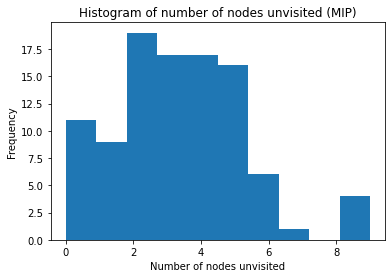

In [24]:
# unvisitied in each route
unvisited = list(map(lambda x: get_unvisited(x, num_nodes), results["mip"]["routes"]))
num_unvisited = list(map(lambda x: len(x), unvisited))

plt.hist(num_unvisited)

plt.title("Histogram of number of nodes unvisited (MIP)")
plt.xlabel("Number of nodes unvisited")
plt.ylabel("Frequency")
plt.show()

#### NN

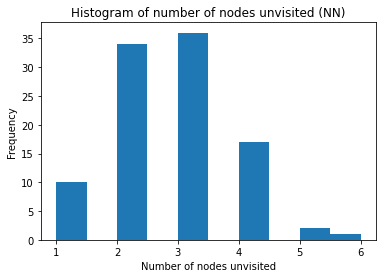

In [25]:
# unvisitied in each route
unvisited = list(map(lambda x: get_unvisited(x, num_nodes), results["nn"]["routes"]))
num_unvisited = list(map(lambda x: len(x), unvisited))

plt.hist(num_unvisited)

plt.title("Histogram of number of nodes unvisited (NN)")
plt.xlabel("Number of nodes unvisited")
plt.ylabel("Frequency")
plt.show()

#### RL

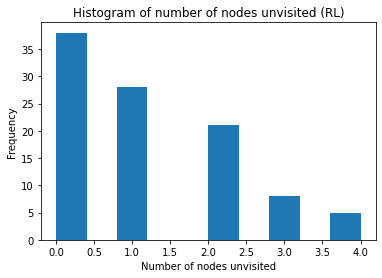

In [26]:
if rl_agent is not None:
    # unvisitied in each route
    unvisited = list(map(lambda x: get_unvisited(x, num_nodes), results["rl"]["routes"]))
    num_unvisited = list(map(lambda x: len(x), unvisited))
    
    plt.hist(num_unvisited)

    plt.title("Histogram of number of nodes unvisited (RL)")
    plt.xlabel("Number of nodes unvisited")
    plt.ylabel("Frequency")
    plt.show()

### Renfer

In [31]:
seed = 1

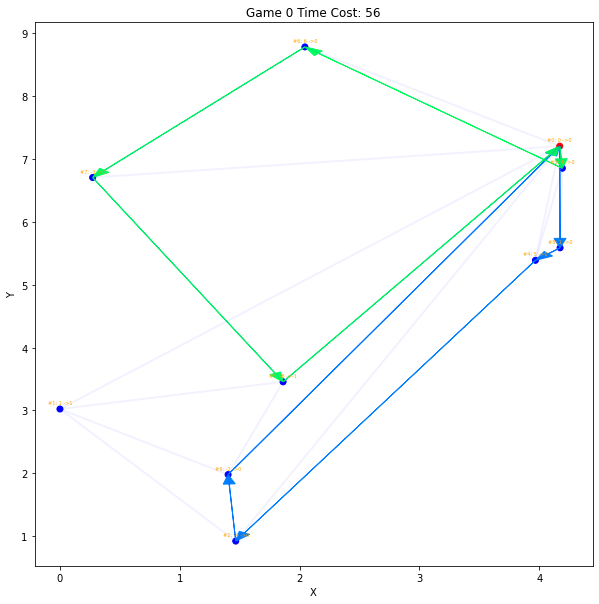

In [32]:
render_mip(g, seed, mip_params)

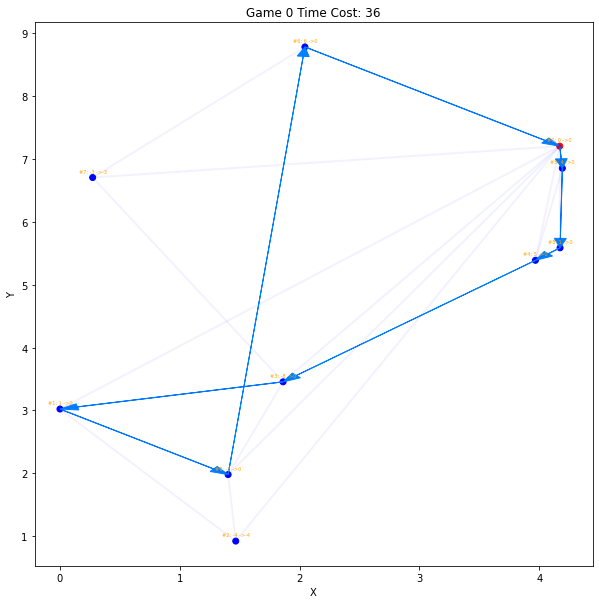

In [33]:
render_nn(g, seed, mip_params)

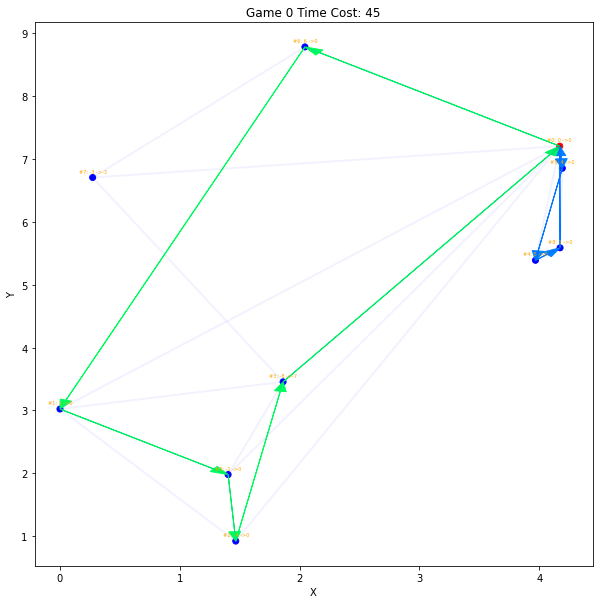

In [34]:
render_rl(g, seed, rl_agent)